---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-data-analysis/resources/0dhYG) course resource._

---

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import ttest_ind

# Assignment 4 - Hypothesis Testing
This assignment requires more individual learning than previous assignments - you are encouraged to check out the [pandas documentation](http://pandas.pydata.org/pandas-docs/stable/) to find functions or methods you might not have used yet, or ask questions on [Stack Overflow](http://stackoverflow.com/) and tag them as pandas and python related. And of course, the discussion forums are open for interaction with your peers and the course staff.

Definitions:
* A _quarter_ is a specific three month period, Q1 is January through March, Q2 is April through June, Q3 is July through September, Q4 is October through December.
* A _recession_ is defined as starting with two consecutive quarters of GDP decline, and ending with two consecutive quarters of GDP growth.
* A _recession bottom_ is the quarter within a recession which had the lowest GDP.
* A _university town_ is a city which has a high percentage of university students compared to the total population of the city.

**Hypothesis**: University towns have their mean housing prices less effected by recessions. Run a t-test to compare the ratio of the mean price of houses in university towns the quarter before the recession starts compared to the recession bottom. (`price_ratio=quarter_before_recession/recession_bottom`)

The following data files are available for this assignment:
* From the [Zillow research data site](http://www.zillow.com/research/data/) there is housing data for the United States. In particular the datafile for [all homes at a city level](http://files.zillowstatic.com/research/public/City/City_Zhvi_AllHomes.csv), ```City_Zhvi_AllHomes.csv```, has median home sale prices at a fine grained level.
* From the Wikipedia page on college towns is a list of [university towns in the United States](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States) which has been copy and pasted into the file ```university_towns.txt```.
* From Bureau of Economic Analysis, US Department of Commerce, the [GDP over time](http://www.bea.gov/national/index.htm#gdp) of the United States in current dollars (use the chained value in 2009 dollars), in quarterly intervals, in the file ```gdplev.xls```. For this assignment, only look at GDP data from the first quarter of 2000 onward.

Each function in this assignment below is worth 10%, with the exception of ```run_ttest()```, which is worth 50%.

In [58]:
# Use this dictionary to map state names to two letter acronyms
states = {'OH': 'Ohio', 'KY': 'Kentucky', 'AS': 'American Samoa', 'NV': 'Nevada', 'WY': 'Wyoming', 'NA': 'National', 'AL': 'Alabama', 'MD': 'Maryland', 'AK': 'Alaska', 'UT': 'Utah', 'OR': 'Oregon', 'MT': 'Montana', 'IL': 'Illinois', 'TN': 'Tennessee', 'DC': 'District of Columbia', 'VT': 'Vermont', 'ID': 'Idaho', 'AR': 'Arkansas', 'ME': 'Maine', 'WA': 'Washington', 'HI': 'Hawaii', 'WI': 'Wisconsin', 'MI': 'Michigan', 'IN': 'Indiana', 'NJ': 'New Jersey', 'AZ': 'Arizona', 'GU': 'Guam', 'MS': 'Mississippi', 'PR': 'Puerto Rico', 'NC': 'North Carolina', 'TX': 'Texas', 'SD': 'South Dakota', 'MP': 'Northern Mariana Islands', 'IA': 'Iowa', 'MO': 'Missouri', 'CT': 'Connecticut', 'WV': 'West Virginia', 'SC': 'South Carolina', 'LA': 'Louisiana', 'KS': 'Kansas', 'NY': 'New York', 'NE': 'Nebraska', 'OK': 'Oklahoma', 'FL': 'Florida', 'CA': 'California', 'CO': 'Colorado', 'PA': 'Pennsylvania', 'DE': 'Delaware', 'NM': 'New Mexico', 'RI': 'Rhode Island', 'MN': 'Minnesota', 'VI': 'Virgin Islands', 'NH': 'New Hampshire', 'MA': 'Massachusetts', 'GA': 'Georgia', 'ND': 'North Dakota', 'VA': 'Virginia'}

In [59]:
def get_list_of_university_towns():
    '''Returns a DataFrame of towns and the states they are in from the 
    university_towns.txt list. The format of the DataFrame is:
    DataFrame( [ ["Michigan", "Ann Arbor"], ["Michigan", "Yipsilanti"] ], 
    columns=["State", "RegionName"]  )
    
    The following cleaning needs to be done:

    1. For "State", removing characters from "[" to the end.
    2. For "RegionName", when applicable, removing every character from " (" to the end.
    3. Depending on how you read the data, you may need to remove newline character '\n'. '''
    
    # Read in text data
    file_name = "university_towns.txt"
    t_file = open(file_name, "r")
    lines = t_file.read().split("\n")
    
    # Parse into town and state data
    state_towns = []
    state = ""
    for line in lines:
        # Check if it is a state name
        if "edit" in line:
            # Remove portion after "["
            state = line[:line.find("[")]
        elif line:
            # Remove portion after " ("
            town = line[:line.find(" (")]
            state_towns.append((state, town))
            
    # Convert to dataframe
    df_towns = pd.DataFrame(state_towns, columns = ['State' , 'RegionName']) 

    return df_towns

get_list_of_university_towns()

,State,RegionName
0,Alabama,Auburn
1,Alabama,Florence
2,Alabama,Jacksonville
3,Alabama,Livingston
4,Alabama,Montevallo
5,Alabama,Troy
6,Alabama,Tuscaloosa
7,Alabama,Tuskegee
8,Alaska,Fairbanks
9,Arizona,Flagstaff


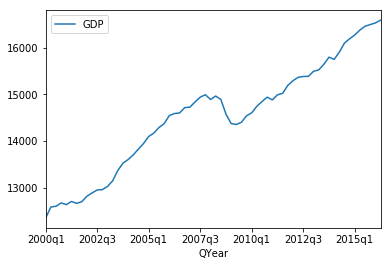

Recession start: 2008q4, Recession bottom: 14355.6, Recession end: 2009q4


('2008q4', 14355.6, '2009q4')

In [118]:
def get_recession_start():
    '''Returns the year and quarter of the recession start time as a 
    string value in a format such as 2005q3
    Only considering GDP data from the 2000q1 onward. 
    
    A recession is defined as starting with two consecutive quarters 
    of GDP decline, and ending with two consecutive quarters of GDP growth.
    
    A recession bottom is the quarter within a recession which had the lowest GDP.'''
    
    # Read in GDP data
    gdp = pd.read_excel("gdplev.xls",
                        skiprows = 7,
                        parse_cols = [4,6],
                        names = ["QYear", "GDP"]).set_index("QYear")  
    pos = gdp.index.get_loc("2000q1")
    gdp = gdp.iloc[pos:, :].reset_index()

    # Plotting GDP over quarters
    gdp.plot(x = "QYear", y = "GDP", kind = "line")
    plt.show()

    rec = False
    rec_start = ""
    rec_bottom = math.inf
    rec_end = ""
    
    for i in range(2, len(gdp)):
        gdp_curr = gdp.at[i, "GDP"]
        gdp_prev1 = gdp.at[i-1, "GDP"]
        gdp_prev2 = gdp.at[i-2, "GDP"]
        
        if (gdp_curr < gdp_prev1) and (gdp_prev1 < gdp_prev2):
            rec = True
            if rec_start == "":
                rec_start = gdp.at[i, "QYear"]
            rec_bottom = min(rec_bottom, gdp_curr)
                
        if (rec == True) and (gdp_curr > gdp_prev1) and (gdp_prev1 > gdp_prev2):
            rec = False
            rec_end = gdp.at[i, "QYear"]      
    
    print(f"Recession start: {rec_start}, Recession bottom: {rec_bottom}, Recession end: {rec_end}")
    
    soln = (rec_start, rec_bottom, rec_end)
    
    return soln

get_recession_start()

In [ ]:
def get_recession_end():
    '''Returns the year and quarter of the recession end time as a 
    string value in a format such as 2005q3'''
       
    return "ANSWER"

In [ ]:
def get_recession_bottom():
    '''Returns the year and quarter of the recession bottom time as a 
    string value in a format such as 2005q3'''
    
    return "ANSWER"

In [ ]:
def convert_housing_data_to_quarters():
    '''Converts the housing data to quarters and returns it as mean 
    values in a dataframe. This dataframe should be a dataframe with
    columns for 2000q1 through 2016q3, and should have a multi-index
    in the shape of ["State","RegionName"].
    
    Note: Quarters are defined in the assignment description, they are
    not arbitrary three month periods.
    
    The resulting dataframe should have 67 columns, and 10,730 rows.
    '''
    
    return "ANSWER"

In [ ]:
def run_ttest():
    '''First creates new data showing the decline or growth of housing prices
    between the recession start and the recession bottom. Then runs a ttest
    comparing the university town values to the non-university towns values, 
    return whether the alternative hypothesis (that the two groups are the same)
    is true or not as well as the p-value of the confidence. 
    
    Return the tuple (different, p, better) where different=True if the t-test is
    True at a p<0.01 (we reject the null hypothesis), or different=False if 
    otherwise (we cannot reject the null hypothesis). The variable p should
    be equal to the exact p value returned from scipy.stats.ttest_ind(). The
    value for better should be either "university town" or "non-university town"
    depending on which has a lower mean price ratio (which is equivilent to a
    reduced market loss).'''
    
    return "ANSWER"